
# <p style="text-align: center;">EE 461P: Data Science Principles</p>
# <p style="text-align: center;">Assignment 5</p>
## <p style="text-align: center;">Total points: 40</p>
## <p style="text-align: center;">Due: Thursday, November 30th, submitted via Canvas by 11:59 pm</p>
### <p style="text-align: center;">Jayaj Poudel and Kevin Yee</p>
### <p style="text-align: center;">Jp49672 and kjy252</p>
Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group.  

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

# Question 1: Ensembles (1+12+2 = 15pts)
In this question, we will compare performance of different ensemble methods: [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [Gradient Boosting Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (GBDT), and [XGBoost](http://xgboost.readthedocs.io/en/latest/).  Note that you have to install xgboost package in addition to scikit-learn.  You can see installation guides [here](http://xgboost.readthedocs.io/en/latest/build.html).




Two  datasets are provided for this problem. For **each of the datasets ((X1.csv, y1.csv), (X2.csv, y2.csv))**, do the following:

1. Load the data and partition it into features (X) and the target label (y) for classification task. Then, use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split data into training and testing: test_size=0.33, random_state=42.

2. Build a classifier using [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [Gradient Boosting Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), and [XGBoost](http://xgboost.readthedocs.io/en/latest/), respectively, and answer the following for each classifier.

 - Mention any design choices (with reasoning/justification) that you made, e.g. the hyperparameters considered for each classifier.
 - Report the mean error rate (fraction of incorrect labels) and the confusion matrix on test data. <br>
 - Report the feature importance and time of execution (training and predicting times).

3. Compare the three classifiers for the two different datasets ((X1.csv, y1.csv), (X2.csv, y2.csv)) in terms of the misclassification rate.  What are the characteristics of the dataset and the classifiers that resulted in somewhat different comparative results?

In [25]:
import numpy as np
import pandas as pd
import timeit
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import zero_one_loss
from xgboost.sklearn import XGBClassifier
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

## Dataset 1

### Load data in

In [34]:
# load data in
dataX1 = pd.read_csv("X1.csv")


colNames = []
for i in range(0,dataX1.shape[1]):
    colNames.append(i)
    
dataX1 = pd.read_csv("X1.csv", names = colNames)
targetY1 = pd.read_csv("Y1.csv", names = ['y'])
# split features 
X_train1, X_test1, y_train1,y_test1 = train_test_split(dataX1, targetY1, test_size=0.33, random_state=42)

X_train1.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
8371,-1.649719,1.176245,-2.039881,-0.478870,-0.070298,-0.762115,-0.795423,-2.306197,-1.982519,0.032758,...,-1.511817,-0.298953,0.150190,0.097169,0.107654,-2.494602,0.015803,2.469424,0.290024,0.585001
5027,-2.800194,0.683859,-0.177587,-0.496900,1.200335,-1.024381,0.871439,-1.783368,0.149218,-0.487374,...,-0.526128,0.093952,-3.155403,0.537268,-0.449454,-0.834588,0.138224,1.262711,-0.939828,0.036371
9234,-1.930278,-1.485537,1.326368,-1.032879,1.113461,0.752487,-0.511190,1.756748,1.241512,-1.043416,...,-1.481338,0.104191,0.126290,-0.923395,-0.813220,0.507418,0.299762,0.837458,0.360729,0.637715
3944,-0.890298,2.057592,0.294119,-0.041669,-0.279400,-0.939085,-1.869124,-1.165352,-0.711337,1.593815,...,0.228440,-1.205651,-2.591204,-0.035392,-1.299204,0.666743,0.342322,0.455440,-0.868818,0.698854
6862,-2.341212,-0.861124,-0.166122,0.596955,-0.397331,-1.196161,-0.629864,-1.321675,-1.417548,-0.463296,...,2.542832,1.825602,-0.802293,1.169343,1.460272,-0.616649,0.219613,-0.332764,0.748059,-0.974091


### Design Choices of Finding Hyperparameters

Hyperparamters were chosen using GridSearchCV using initial values suggested by https://www.analyticsvidhya.com.
As advised, the main parameter tested was 'n_estimators'. However, we kept this number low for the sake of time complexity.

In addition to testing for n_estimators we tested:

1) For Random Forest Classifier, the min_samples_leaf was tested in the Grid Search
2) For Gradient Boosting Classifier, the learning rate was tested in the Grid Search
3) For XGBoost Classifier, the max_depth was tested in the Grid Search

We used 5 Fold CV to gain our optimal paramters. Below is the output:

In [14]:
# Grid Search CV to find best hyper parameters

RFC = RandomForestClassifier()

# Creating Parameters as suggested by: 
# https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

params = { 'n_estimators' : [30,60,100], 'min_samples_leaf' : [50, 70, 90] }

# Run GridSearch to find best Parmas for Random Forest on 5-fold CV
gridCV = GridSearchCV(estimator = RFC, param_grid = params, cv = 5, n_jobs = -1)
gridCV.fit(X_train1.values, y_train1.values.ravel())

print("\n Grid Score CV Results for Random Forest")
print ("Best Estimator", gridCV.best_estimator_)
print ("Best Score",gridCV.best_score_)
print ("Best Params", gridCV.best_params_)

('Best Estimator', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
('Best Score', 0.85057471264367812)
('Best Params', {'n_estimators': 100, 'min_samples_leaf': 50})


In [17]:
gbm = GradientBoostingClassifier()

# Creating Parameters as suggested by: 
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

params = { 'n_estimators' : [30,60,100], 
          'learning_rate' : [0.01, 0.1, 0.2] }

# Run GridSearch to find best Parmas for Gradient Boosting CLassifier on 5-fold CV
gridCV = GridSearchCV(estimator = gbm, param_grid = params, cv = 5, n_jobs = -1)
gridCV.fit(X_train1.values, y_train1.values.ravel())

print("\n Grid Score CV Results for Gradient Boost Classifier")
print ("Best Estimator", gridCV.best_estimator_)
print ("Best Score",gridCV.best_score_)
print ("Best Params", gridCV.best_params_)


 Grid Score CV Results for Gradient Boost Classifier
('Best Estimator', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))
('Best Score', 0.88804299149126731)
('Best Params', {'n_estimators': 100, 'learning_rate': 0.2})


In [18]:
xgb = XGBClassifier()

# Creating Parameters as suggested by: 
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

params = { 'n_estimators' : [30,60,100], 
          'max_depth' : [4, 6, 8] }

# Run GridSearch to find best Parmas for Gradient Boosting CLassifier on 5-fold CV
gridCV = GridSearchCV(estimator = xgb, param_grid = params, cv = 5, n_jobs = -1)
gridCV.fit(X_train1.values, y_train1.values.ravel())

print("\n Grid Score CV Results for XGBoost Classifier")
print ("Best Estimator", gridCV.best_estimator_)
print ("Best Score",gridCV.best_score_)
print ("Best Params", gridCV.best_params_)


 Grid Score CV Results for XGBoost Classifier
('Best Estimator', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))
('Best Score', 0.92148081803254211)
('Best Params', {'n_estimators': 100, 'max_depth': 8})


### Reporting Mean Error Rate + Confusion Matrix on Test data. 


Mean Error Rate for Random Forest Classifier: 0.146060606061

Mean Error Rate for Gradient Boosting Classifier: 0.113333333333

Mean Error Rate for XGBoost Classifier: 0.0766666666667


C:\Users\Kevin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


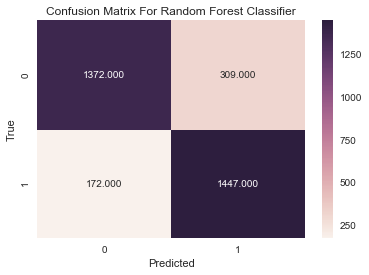

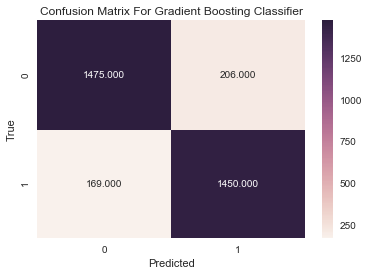

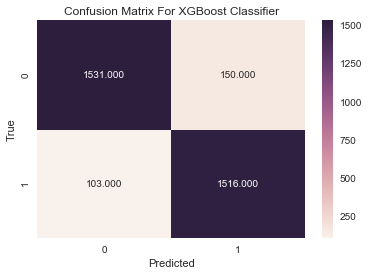

In [48]:
rfc = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 50)
gbm = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.2)
xgb = XGBClassifier(n_estimators = 100, max_depth = 8)

### Random Forest Classifier ###

## Train RFC
beg_ts = time()
rfc.fit(X_train1, y_train1)
end_ts = time()
elapsed_rfc_train_time = end_ts - beg_ts

## Pred RFC
beg_ts = time()
rfc_preds = rfc.predict(X_test1)
end_ts = time()
elapsed_rfc_predict_time = end_ts - beg_ts

### Gradient Boosting Classifier ###

## Train GBM
beg_ts = time()
gbm.fit(X_train1, y_train1)
end_ts = time()
elapsed_gbm_train_time = end_ts - beg_ts

## Pred GBM
beg_ts = time()
gbm_preds = gbm.predict(X_test1)
end_ts = time()
elapsed_gbm_predict_time = end_ts - beg_ts

### XGB Classifier ###

## Train XGB
beg_ts = time()
xgb.fit(X_train1, y_train1)
end_ts = time()
elapsed_xgb_train_time = end_ts - beg_ts

## Pred XGB
beg_ts = time()
xgb_preds = xgb.predict(X_test1)
end_ts = time()
elapsed_xgb_predict_time = end_ts - beg_ts

print "\nMean Error Rate for Random Forest Classifier: " + str(zero_one_loss(y_test1,rfc_preds))
print "\nMean Error Rate for Gradient Boosting Classifier: " + str(zero_one_loss(y_test1,gbm_preds))
print "\nMean Error Rate for XGBoost Classifier: " + str(zero_one_loss(y_test1,xgb_preds))

sns.heatmap(conf_matrix_rfc,annot=True,fmt=".3f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix For Random Forest Classifier")

plt.show()

sns.heatmap(conf_matrix_gbm,annot=True,fmt=".3f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix For Gradient Boosting Classifier")
plt.show()

sns.heatmap(conf_matrix_xgb,annot=True,fmt=".3f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix For XGBoost Classifier")
plt.show()

### Feature importance and Time of execution (training and predicting times)

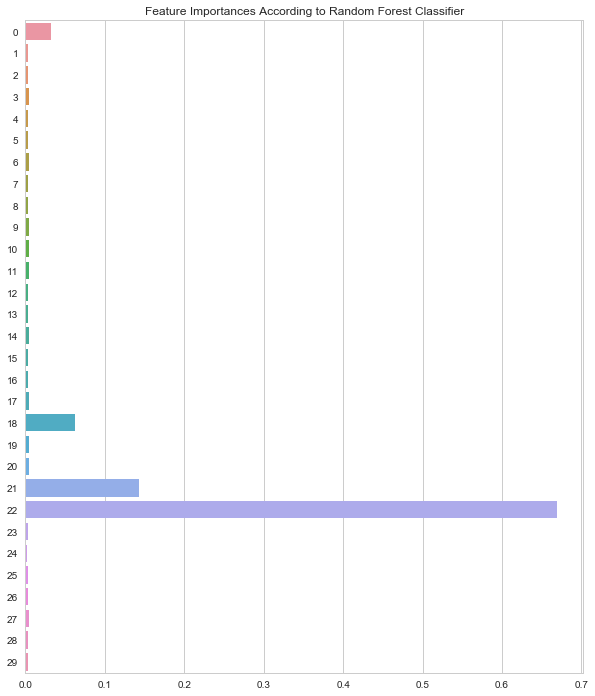

In [53]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=rfc.feature_importances_, y=X_train1.columns,orient ="h")
plt.title("Feature Importances According to Random Forest Classifier")
plt.show()

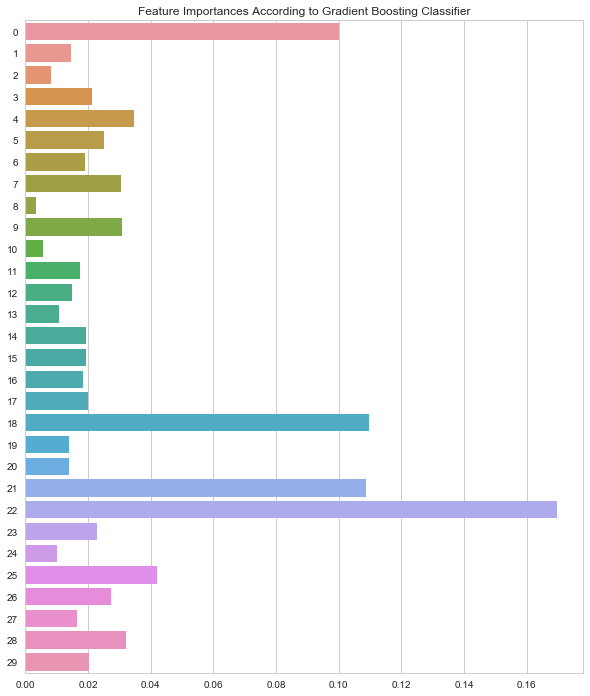

In [55]:

sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=gbm.feature_importances_,y=X_train1.columns, orient = 'h')
plt.title("Feature Importances According to Gradient Boosting Classifier")
plt.show()



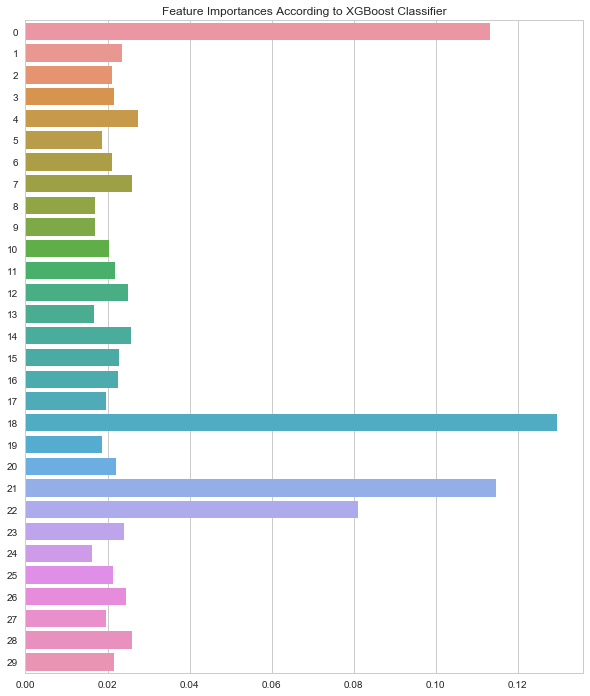

In [54]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=xgb.feature_importances_,y=X_train1.columns, orient = 'h')
plt.title("Feature Importances According to XGBoost Classifier")
plt.show()

The most important features in RandomForest and GradientBoost was Feature 22 

The most important features in XGBoost was Feature 18

In [59]:
print "\nRandom Forest Times: "
print "Training Time (secs): %.3f" % elapsed_rfc_train_time 
print "Predicting Time (secs): %.3f" % elapsed_rfc_predict_time

print "\nGradient Boosting Times: "
print "Training Time (secs): %.3f" % elapsed_gbm_train_time
print "Predicting Time (secs): %.3f" % elapsed_gbm_predict_time


print "\nXGBoosting Times: "
print "Training Time (secs): %.3f" % elapsed_xgb_train_time
print "Predicting Time (secs): %.3f" % elapsed_xgb_predict_time


Random Forest Times: 
Training Time (secs): 4.184
Predicting Time (secs): 0.071

Gradient Boosting Times: 
Training Time (secs): 5.031
Predicting Time (secs): 0.009

XGBoosting Times: 
Training Time (secs): 7.406
Predicting Time (secs): 0.042


## Dataset 2

In [63]:
# load data in
dataX2 = pd.read_csv("X2.csv")


colNames = []
for i in range(0,dataX2.shape[1]):
    colNames.append(i)
    
dataX2 = pd.read_csv("X2.csv", names = colNames)
targetY2 = pd.read_csv("Y2.csv", names = ['y'])
# split features 
X_train2, X_test2, y_train2, y_test2 = train_test_split(dataX2, targetY2, test_size=0.33, random_state=42)

X_train2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1522,2.300477,0.363770,0.144339,-0.558788,1.707447,-4.474695,1.839600,2.459295,3.828094,1.549987,0.252517,-1.777784,0.873365,-0.883064,0.902041,-0.078877,-2.489599,0.768784,3.327456,0.728037
835,-0.109199,0.212967,0.549064,-1.241836,1.960115,0.657332,-2.455211,-2.225724,-4.990068,0.050653,-2.349657,1.515976,1.055816,-0.752454,-0.200222,2.208993,2.978494,-0.895843,-4.034914,0.737746
358,1.369038,0.478174,0.328843,-0.788425,1.909545,-2.544886,-1.894744,1.084245,-1.244259,0.849203,-1.603663,0.508336,1.294782,0.142815,0.103085,1.419244,-2.938557,-0.556318,1.912863,1.791105
138,-1.021278,-1.482523,-1.084386,1.627551,0.837333,-0.127461,-1.288318,-1.537706,1.955051,2.121180,-0.869797,-2.409449,-0.497299,-0.236416,1.923061,4.109815,-0.789706,-0.850928,-1.740679,-0.376976
299,1.617604,-1.390829,0.475023,-1.791082,-0.632696,2.367605,1.146786,0.600876,-0.480133,1.930179,-4.115812,1.206437,0.865262,0.652520,-0.017445,-0.558426,2.747832,1.038659,4.870268,-1.560821


### Design Choices of Finding Hyperparameters

In addition to testing for n_estimators we tested:

1) For Random Forest Classifier, the min_samples_leaf was tested in the Grid Search

2) For Gradient Boosting Classifier, the learning rate was tested in the Grid Search

3) For XGBoost Classifier, the max_depth was tested in the Grid Search

We used 5 Fold CV to gain our optimal paramters. Below is the output:
    

In [66]:
# Grid Search CV to find best hyper parameters

RFC = RandomForestClassifier()

# Creating Parameters as suggested by: 
# https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

params = { 'n_estimators' : [30,60,100], 'min_samples_leaf' : [50, 70, 90] }

# Run GridSearch to find best Parmas for Random Forest on 5-fold CV
gridCV = GridSearchCV(estimator = RFC, param_grid = params, cv = 5, n_jobs = -1)
gridCV.fit(X_train2.values, y_train2.values.ravel())

print("\n Grid Score CV Results for Random Forest")
print ("Best Estimator", gridCV.best_estimator_)
print ("Best Score",gridCV.best_score_)
print ("Best Params", gridCV.best_params_)


gbm = GradientBoostingClassifier()

# Creating Parameters as suggested by: 
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

params = { 'n_estimators' : [30,60,100], 
          'learning_rate' : [0.01, 0.1, 0.2] }

# Run GridSearch to find best Parmas for Gradient Boosting CLassifier on 5-fold CV
gridCV = GridSearchCV(estimator = gbm, param_grid = params, cv = 5, n_jobs = -1)
gridCV.fit(X_train2.values, y_train2.values.ravel())

print("\n Grid Score CV Results for Gradient Boost Classifier")
print ("Best Estimator", gridCV.best_estimator_)
print ("Best Score",gridCV.best_score_)
print ("Best Params", gridCV.best_params_)


xgb = XGBClassifier()
# Creating Parameters as suggested by: 
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

params = { 'n_estimators' : [30,60,100], 
          'max_depth' : [4, 6, 8] }

# Run GridSearch to find best Parmas for Gradient Boosting CLassifier on 5-fold CV
gridCV = GridSearchCV(estimator = xgb, param_grid = params, cv = 5, n_jobs = -1)
gridCV.fit(X_train2.values, y_train2.values.ravel())


print("\n Grid Score CV Results for XGBoost Classifier")
print ("Best Estimator", gridCV.best_estimator_)
print ("Best Score",gridCV.best_score_)
print ("Best Params", gridCV.best_params_)


 Grid Score CV Results for Random Forest
('Best Estimator', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
('Best Score', 0.87373134328358204)
('Best Params', {'n_estimators': 100, 'min_samples_leaf': 50})

 Grid Score CV Results for Gradient Boost Classifier
('Best Estimator', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.

### Reporting Mean Error Rate + Confusion Matrix on Test data. 


Mean Error Rate for Random Forest Classifier: 0.110909090909

Mean Error Rate for Gradient Boosting Classifier: 0.0775757575758

Mean Error Rate for XGBoost Classifier: 0.0551515151515


C:\Users\Kevin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


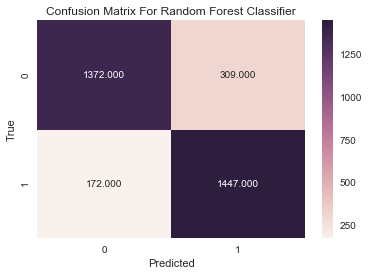

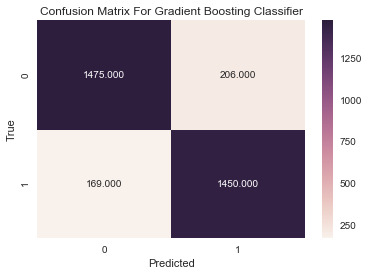

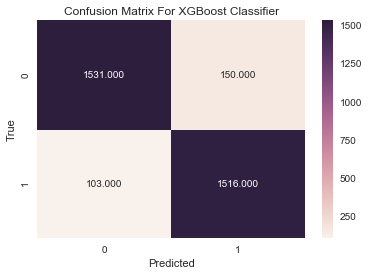

In [67]:
rfc = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 50)
gbm = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.2)
xgb = XGBClassifier(n_estimators = 100, max_depth = 8)

### Random Forest Classifier ###

## Train RFC
beg_ts = time()
rfc.fit(X_train2, y_train2)
end_ts = time()
elapsed_rfc_train_time = end_ts - beg_ts

## Pred RFC
beg_ts = time()
rfc_preds = rfc.predict(X_test2)
end_ts = time()
elapsed_rfc_predict_time = end_ts - beg_ts

### Gradient Boosting Classifier ###

## Train GBM
beg_ts = time()
gbm.fit(X_train2, y_train2)
end_ts = time()
elapsed_gbm_train_time = end_ts - beg_ts

## Pred GBM
beg_ts = time()
gbm_preds = gbm.predict(X_test2)
end_ts = time()
elapsed_gbm_predict_time = end_ts - beg_ts

### XGB Classifier ###

## Train XGB
beg_ts = time()
xgb.fit(X_train2, y_train2)
end_ts = time()
elapsed_xgb_train_time = end_ts - beg_ts

## Pred XGB
beg_ts = time()
xgb_preds = xgb.predict(X_test2)
end_ts = time()
elapsed_xgb_predict_time = end_ts - beg_ts

print "\nMean Error Rate for Random Forest Classifier: " + str(zero_one_loss(y_test2,rfc_preds))
print "\nMean Error Rate for Gradient Boosting Classifier: " + str(zero_one_loss(y_test2,gbm_preds))
print "\nMean Error Rate for XGBoost Classifier: " + str(zero_one_loss(y_test2,xgb_preds))

sns.heatmap(conf_matrix_rfc,annot=True,fmt=".3f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix For Random Forest Classifier")

plt.show()

sns.heatmap(conf_matrix_gbm,annot=True,fmt=".3f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix For Gradient Boosting Classifier")
plt.show()

sns.heatmap(conf_matrix_xgb,annot=True,fmt=".3f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix For XGBoost Classifier")
plt.show()

### Feature importance and Time of execution (training and predicting times)

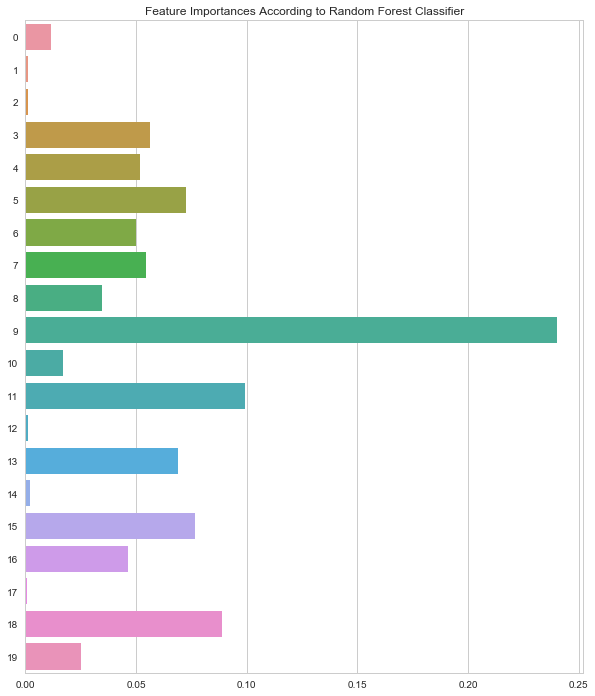

In [68]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=rfc.feature_importances_, y=X_train2.columns,orient ="h")
plt.title("Feature Importances According to Random Forest Classifier")
plt.show()

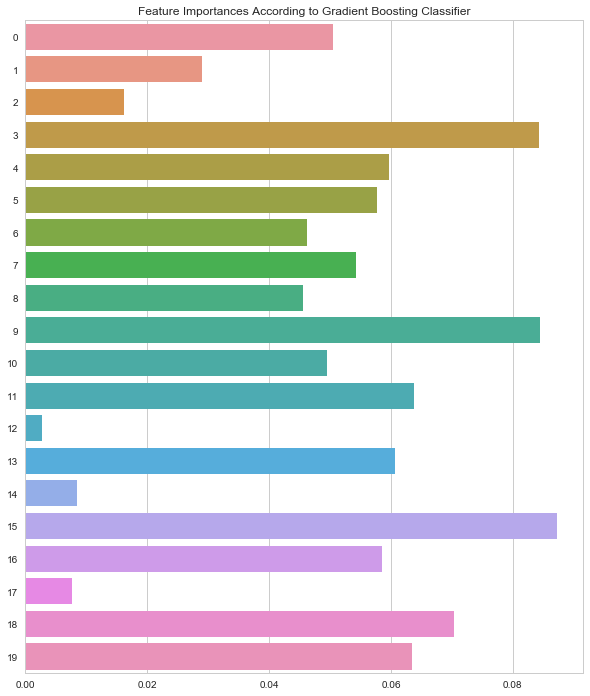

In [70]:

sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=gbm.feature_importances_,y=X_train2.columns, orient = 'h')
plt.title("Feature Importances According to Gradient Boosting Classifier")
plt.show()



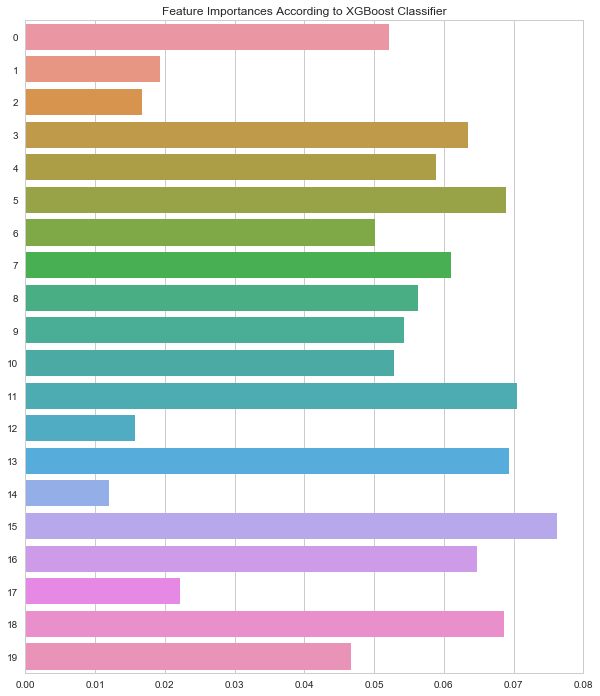

In [71]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=xgb.feature_importances_,y=X_train2.columns, orient = 'h')
plt.title("Feature Importances According to XGBoost Classifier")
plt.show()

In [72]:
print "\nRandom Forest Times: "
print "Training Time (secs): %.3f" % elapsed_rfc_train_time 
print "Predicting Time (secs): %.3f" % elapsed_rfc_predict_time

print "\nGradient Boosting Times: "
print "Training Time (secs): %.3f" % elapsed_gbm_train_time
print "Predicting Time (secs): %.3f" % elapsed_gbm_predict_time


print "\nXGBoosting Times: "
print "Training Time (secs): %.3f" % elapsed_xgb_train_time
print "Predicting Time (secs): %.3f" % elapsed_xgb_predict_time


Random Forest Times: 
Training Time (secs): 1.295
Predicting Time (secs): 0.077

Gradient Boosting Times: 
Training Time (secs): 2.364
Predicting Time (secs): 0.011

XGBoosting Times: 
Training Time (secs): 1.812
Predicting Time (secs): 0.012


### Comparing the Classifiers for the 2 datasets:

For both Dataset 1 and Dataset 2:
The following classifiers performed as follows:


* Dataset 1 Mean Error Rate
    * RandomForest: 0.14
    * GradientBoost: 0.11
    * XGBoost: 0.07
    
* Dataset 2 Mean Error Rate
    * RandomForest: 0.11
    * GradientBoost: 0.07
    * XGBoost: 0.05
    
XGBoost had the lowest mean error rate while random forest had the highest.

Dataset 2 had a lower mean error rate than Dataset 1 becuase the features in Dataset 2 had similiar F1 score importance (according the feature importance charts above).

Only having one feature with importance while having other features with little importance performs poorly on a tree-based models. Thus the tree based models did not perform as well on Dataset 1

# Question 2: Visualization using Bokeh (10 pts)

In this problem, you'll build an interactive visualization. Bokeh is a Python interactive visualization library that targets modern web browsers for presentation. For more information on Bokeh, see http://bokeh.pydata.org/en/latest/. The problem statement is as follows:

Using the "nbasalariesfull.csv" data set from HMK4, your goal is to build a Bokeh visualization which allows the user to explore how salary (on a log scale) varies with points per game (PSG) and age. You will create a visualization that allows the user to toggle the X axis of a scatter plot between PSG and age, with the y-axis always being log Salary. Also add the hover tool so that if the user hovers over a datapoint in the plot a window pops up that shows the player name, team, position, salary, and the current x variable (PSG or age) depending on the current tab.  Color each point according to a player's position and provide a legend for the colors. Add the ability to Zoom in/out.  Add slight horizontal jitter to a player's age.

Hints: 
1. see: http://bokeh.pydata.org/en/latest/docs/user_guide/tools.html#basic-tooltips for hover and zoom tool examples.
2. See: http://bokeh.pydata.org/en/latest/docs/reference/plotting.html. Look for the scatter API.
3. See: http://bokeh.pydata.org/en/0.10.0/docs/user_guide/styling.html#labels. For labeling axes.
4. See: https://bokeh.pydata.org/en/latest/docs/user_guide/categorical.html  for how to use jitter transform
5. Use output_notebook() from Bokeh to output the plot to your notebook

In [8]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import CustomJS, ColumnDataSource, HoverTool, BoxZoomTool, ResetTool
from bokeh.transform import jitter
from bokeh.transform import factor_cmap
from bokeh.palettes import inferno
from bokeh.plotting import figure, output_notebook, show

data = pd.read_csv("nbasalariesfull.csv")
data["logsalary"] = data.SALARY.apply(np.log)

# Question 3: Clustering (15 pts)
## Part a

This problem explores scaling, clustering, and one method of evaluating the quality of a clustering. You will also examine some of the issues in k-means clustering, and some ways to mitigate these problems. You will be using Fisher's Iris dataset available in sklearn.

We wish to cluster the dataset to find any similar groups of flowers. However, we are not certain that the scales of the various features are well-suited for clustering. We will use scipy's k-means clustering package for this problem.

When calculating the cluster purity, use the following equations:

$ClassPurity(C_i$) = $\frac{1}{|C_i|}\max_j(|C_i|_{class=j})$

$NetPurity$ = $\sum_{i=1}^k\frac{|C_i|}{|D|}purity(C_i)$

where $|C_i|$ is the total number of data points assigned to cluster $C_i$, $|C_i|_{class=j}$ is the number of data points from class $j$ assigned to cluster $C_i$ and $D$ refers to the whole dataset.

1. Cluster the data into 4 clusters, using K-means and calculate the NetPurity for your solution.
2. Now linearly scale each feature so that the values range from 0 to 1. Cluster the data using the k-means algorithm (as before), and calculate the cluster purity for the clustering. Report the calculations you used to scale the features, as well as the NetPurity.
3. Linearly scale the original dataset features so that the distribution of values for each feature has a mean of 0 and a standard deviation of 1. Cluster the data as before, and report the NetPurity obtained.



In [3]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import datasets

## Part b

Run both single link and complete link hierarchical clustering algorithms on the iris dataset, and submit the two dendograms. 

1. For each dendogram, visually inspect it to suggest what value(s) of $k$ (between 1 and 6) seem reasonable to choose for this dataset. 
2. Do you observe any difference in the structure of the 2 dendograms? How do you explain this difference?

In [4]:
% matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import datasets

## Part c

1. What is the cost function minimised in the k-means clustering algorithm?
2. Explain how this can be generalized to be of the form $J = \sum_{i=1}^k n_i s_i$, where $s_i$ is the average squared (Euclidean) distance between pairs of points in cluster $i$ (every point is compared with every point - including itself - in the same cluster, so we have $n_i^2$ comparisions that are averaged over to get $s_i$), 
and $n_i$ is the total number of points in cluster $i$.
3. What would the benefit of such a generalized expression be?

1. Standard Expression, $J = \sum_{i=1}^k \sum_{x \in S_i} ||x-\mu_i||^2$, where \mu_i is the mean of the points in S_i
2. Generalized expression, 
    $J = \sum_{i=1}^k n_i * (||x-\mu_i||^2 /n_i)$ where n_i is the number of samples in each cluster
    
    $J = \sum_{i=1}^k n_i * s_i $ where s_i is the variance within each cluster

3. Benefit: $s_i$ can now be replaced with any similarity metric based on the clustering problem requirements